In [1]:
"""
Evaluate GPT-2 (fine-tuned or base) on partial->remainder conversation data:
- Reads CSV from the user-specified path
- Splits conversation lines into partial vs remainder
- Measures cross-entropy & perplexity
- Also does direct generation for each partial snippet
- Finally visualizes the distribution of sample-level perplexities
"""

import os
import math
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------------
# 1) CSV Input Path
# -----------------------------------------------------------
csv_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/FINAL_DATASET2.csv"
print("CSV file path:", csv_path)
partial_ratio = 0.5  # <--- param: fraction of lines in partial snippet


c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



Using device: cpu
CSV file path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/FINAL_DATASET2.csv


In [2]:
# -----------------------------------------------------------
# 2) Build partial->remainder from CSV
# -----------------------------------------------------------
def build_partial_remainder(csv_path, partial_ratio=0.5):
    """
    Groups lines by conversation ID, sorts by step, 
    then splits each conversation into partial vs remainder
    based on partial_ratio.
    """
    df = pd.read_csv(csv_path)
    pairs = []
    for convo_id, group in df.groupby("CONVERSATION_ID"):
        group_sorted = group.sort_values("CONVERSATION_STEP")
        texts = group_sorted["TEXT"].tolist()
        if len(texts) < 2:
            continue
        cutoff = max(1, int(len(texts)*partial_ratio))
        partial_list = texts[:cutoff]
        remainder_list= texts[cutoff:]
        partial_str = "\n".join(partial_list).strip()
        remainder_str= "\n".join(remainder_list).strip()
        if partial_str and remainder_str:
            pairs.append((partial_str, remainder_str))
    return pairs

pairs = build_partial_remainder(csv_path, partial_ratio)
print("Number of partial->remainder pairs:", len(pairs))
if pairs:
    print("Example pair:\nPartial:", pairs[0][0], "\nRemainder:", pairs[0][1])


Number of partial->remainder pairs: 76
Example pair:
Partial: Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography.
The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Org Name] aims to ensure everyone can learn and grow, regardless of their starting point.
That sounds perfect. What's the registration process? 
Remainder: You can register through our website. I can guide you through the steps if you'd like, or send you a direct link to the registration page.
A direct link would be great. Can you also tell me about the workshop fee?
Certainly, th

In [3]:
# -----------------------------------------------------------
# 3) Prepare a dataset for evaluation
# -----------------------------------------------------------
# We'll combine partial + <|SEP|> + remainder into one text. 
# GPT-2 will do a teacher-forcing pass on that entire text 
# to compute cross-entropy. We can also do direct generation.

SEP_TOKEN = "<|SEP|>"

class ConversationEvalDataset(Dataset):
    """
    Each example is partial + <|SEP|> + remainder.
    We'll store them as a single string so we can measure 
    cross-entropy on the entire text.
    """
    def __init__(self, pairs):
        self.samples = []
        for (partial, remainder) in pairs:
            # combine them
            text = partial + f"\n{SEP_TOKEN}\n" + remainder
            self.samples.append((partial, remainder, text))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        partial, remainder, combined = self.samples[idx]
        return {
            "partial": partial,
            "remainder": remainder,
            "combined_text": combined
        }

eval_dataset = ConversationEvalDataset(pairs)
print("Eval dataset size:", len(eval_dataset))
if len(eval_dataset)>0:
    ex = eval_dataset[0]
    print("Sample partial:", ex["partial"])
    print("Sample remainder:", ex["remainder"])
    print("Combined text:", ex["combined_text"])


Eval dataset size: 76
Sample partial: Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography.
The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Org Name] aims to ensure everyone can learn and grow, regardless of their starting point.
That sounds perfect. What's the registration process?
Sample remainder: You can register through our website. I can guide you through the steps if you'd like, or send you a direct link to the registration page.
A direct link would be great. Can you also tell me about the workshop fee?
Certainly, the fee for the work

In [11]:
# -----------------------------------------------------------
# 4) Load Fine-Tuned GPT-2 Model
# -----------------------------------------------------------
# If you have a local directory with your finetuned GPT-2
# e.g. "gpt2_conversation_predict_model"
model_dir = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/gpt2_conversation_predict_model"
print("Loading GPT-2 from:", model_dir)

tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
# GPT-2 doesn't define pad => let's map pad to eos
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(model_dir)
model.to(device)
model.eval()


Loading GPT-2 from: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/gpt2_conversation_predict_model


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [12]:
# -----------------------------------------------------------
# 5) Evaluate: Cross-Entropy / Perplexity
# -----------------------------------------------------------
# We'll do a teacher-forcing pass:
#   input_ids = combined_text tokens
#   labels    = same
# The model outputs cross-entropy average over the sequence.

def evaluate_cross_entropy(model, tokenizer, dataset, batch_size=2, max_length=256):
    # We'll create a dataloader to iterate
    def collate_fn(batch):
        texts = [b["combined_text"] for b in batch]
        encodings = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"]
        # for causal LM, labels = input_ids
        encodings["labels"] = input_ids.clone()
        return encodings
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    total_loss = 0.0
    total_tokens = 0
    all_sample_losses = []  # we'll store per-sample perplexities for visualization

    model.eval()
    with torch.no_grad():
        for batch_enc in loader:
            input_ids = batch_enc["input_ids"].to(device)
            labels    = batch_enc["labels"].to(device)
            attention_mask = batch_enc["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss  # average cross-entropy for the batch
            # We multiply by #non-pad tokens in the batch to get sum of losses
            pad_id = tokenizer.pad_token_id
            mask = (input_ids != pad_id).float()
            num_tokens_batch = mask.sum().item()

            batch_loss_value = loss.item() * num_tokens_batch
            total_loss += batch_loss_value
            total_tokens += num_tokens_batch

            # store sample-level cross-entropy for each item
            # to do that, we can approximate by dividing batch_loss_value
            # equally among samples or do a more fine-grained approach:
            # we'll do a simpler approach: each sample gets the same share
            B = input_ids.size(0)
            share_per_item = batch_loss_value / B
            tokens_per_item = num_tokens_batch / B
            # cross-entropy per item = share_per_item / tokens_per_item
            # perplexity = exp(cross_entropy)
            for _ in range(B):
                item_crossent = share_per_item / tokens_per_item if tokens_per_item>0 else float("inf")
                all_sample_losses.append(item_crossent)
    
    avg_loss = total_loss / total_tokens if total_tokens>0 else float("inf")
    # final cross-entropy
    ppl = math.exp(avg_loss) if avg_loss<20 else float("inf")
    
    return avg_loss, ppl, all_sample_losses

test_batch_size = 2   # Can Tune
max_seq_len = 256     # Can Tune
crossent, perplexity, sample_losses = evaluate_cross_entropy(
    model, tokenizer, eval_dataset, batch_size=test_batch_size, max_length=max_seq_len
)
print(f"Test Cross-Entropy: {crossent:.4f}")
print(f"Test Perplexity   : {perplexity:.4f}")


Test Cross-Entropy: 2.5454
Test Perplexity   : 12.7489


In [13]:
# -----------------------------------------------------------
# 6) Generating for Each Partial Snippet 
# -----------------------------------------------------------
# We'll do direct generation to see how the model completes partial snippet.

def generate_remainder(model, tokenizer, partial_text, max_new_tokens=50):
    inputs = tokenizer(partial_text, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens, 
            do_sample=False, 
            pad_token_id=tokenizer.eos_token_id
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # The "remainder" is the portion after partial_text
    # You can find the substring if you want
    return full_text

if len(eval_dataset)>0:
    example_data = eval_dataset[0]
    partial_ex = example_data["partial"]
    remainder_ex = example_data["remainder"]
    
    print("=== PARTIAL ===")
    print(partial_ex)
    predicted = generate_remainder(model, tokenizer, partial_ex, max_new_tokens=50)
    print("\n=== MODEL COMPLETION ===")
    print(predicted)
    
    print("\n=== TRUE REMAINDER ===")
    print(remainder_ex)


=== PARTIAL ===
Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography.
The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Org Name] aims to ensure everyone can learn and grow, regardless of their starting point.
That sounds perfect. What's the registration process?

=== MODEL COMPLETION ===
Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's great to hear of your inter

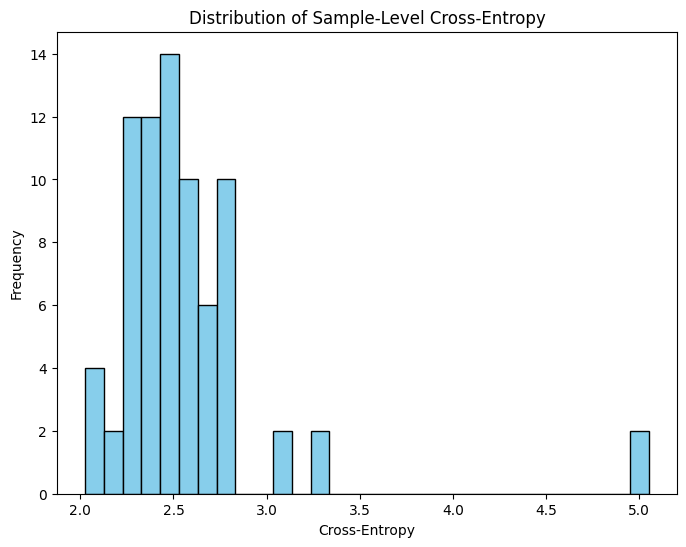

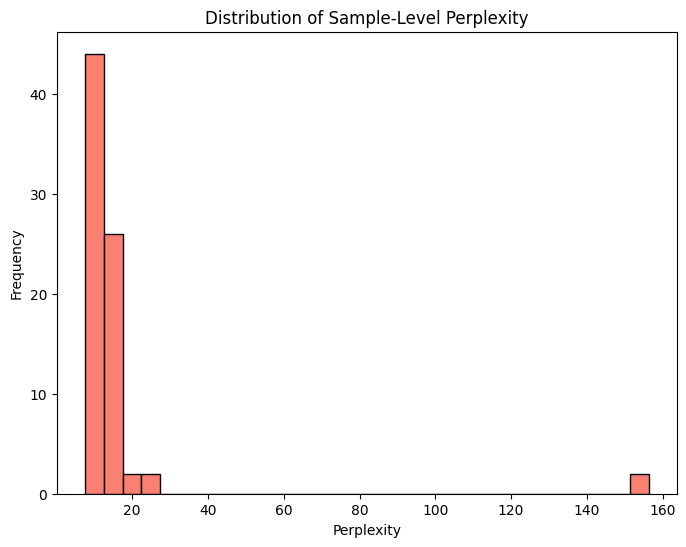

In [14]:
# -----------------------------------------------------------
# 7) Visualization: Sample-Level Cross-Entropy
# -----------------------------------------------------------
# We'll plot a histogram of the sample-level cross-entropies we derived
# from the approximate distribution in evaluate_cross_entropy.

import numpy as np
import matplotlib.pyplot as plt

sample_losses_arr = np.array(sample_losses)
plt.figure(figsize=(8,6))
plt.hist(sample_losses_arr, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Sample-Level Cross-Entropy")
plt.xlabel("Cross-Entropy")
plt.ylabel("Frequency")
plt.show()

# If you want the perplexity distribution:
sample_ppls = np.exp(sample_losses_arr)
plt.figure(figsize=(8,6))
plt.hist(sample_ppls, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Sample-Level Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.show()
